# Data Challenge 2

## Download data

In [3]:
#! pip install -q lalsuite
#! pip install -q gwpy
#! pip install -q pycbc
# -- Click "restart runtime" in the runtime menu

# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf

# -- for gwpy 
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')

--2022-05-26 03:22:56--  https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4025842 (3.8M)
Saving to: ‘challenge2.gwf.1’

challenge2.gwf.1    100%[===================>]   3.84M  2.62MB/s    in 1.5s    

2022-05-26 03:22:58 (2.62 MB/s) - ‘challenge2.gwf.1’ saved [4025842/4025842]



## Sampling rate and duration

In [4]:
duration = len(gwpy_strain)*gwpy_strain.dt
sampling_rate = 1/gwpy_strain.dt
print("duration = {}".format(duration))
print("sampling rate = {}".format(sampling_rate))

duration = 128.0 s
sampling rate = 4096.0 1 / s


## Plotting the data

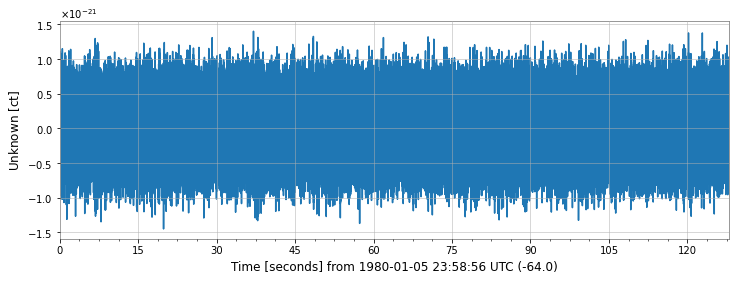

In [5]:
%matplotlib inline
plot = gwpy_strain.plot()

## Q-transform

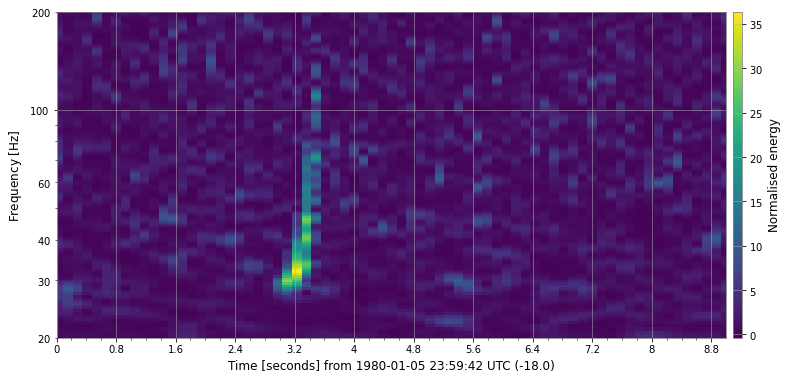

In [17]:
hq = gwpy_strain.q_transform(frange=(20, 200), qrange=(30, 80))
plot_hq = hq.plot()
ax = plot_hq.gca()
ax.set_yscale('log')
ax.set_xlim(46-64, 55-64)
#ax.set_xlim(0, -16)
ax.colorbar(label="Normalised energy")

Merger time: 1980-01-05 23:59:45.6 (3.6-18=-14.4)

# Time domain waveform

In [ ]:
from pycbc.waveform import get_td_waveform
import pylab
%matplotlib inline

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/16384,
                         f_lower=20)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()